<a href="https://colab.research.google.com/github/ProfessorPatrickSlatraigh/CST3512/blob/main/CST3512_NYC_Citibike.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#NYC Citibike    

**from the article '[Using Python to analyze New York City bike sharing data](https://businesscode.medium.com/python-practice-analyzing-new-york-city-bike-sharing-data-using-pandas-3badfd6ab026)' of 09-Mar-2021 on Medium.com by Computer Science for Business Program.**    

*note: while the source article remains on **Medium.com** the source code and dataset files it references are no longer available.  All requisite code is in this notebook and accommodations have been made to access the source date.*   


##Housekeeping    

Open required libraries and modules   


*note: if opening `folium` causes a problem, try to install it with:*    

`!pip install folium`   


In [ ]:
# the usual suspects   
import pandas as pd  
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# to access files inside a compressed zipfile
import zipfile    

# to work with dates and times 
import datetime as dt 

# using folium for mapping    
import folium   

# just in case    
import pprint
pp = pprint.PrettyPrinter(indent=4)  
 



---



##The Dataset    

Millions of New Yorkers rely on the city’s bike ride sharing program, Citi Bikes. The city has thousands of bikes that can be rented from one of several hundred dock stations pictured above.    

The bikes are unlocked electronically so the data from each ride is logged and stored in a database that is shared with the public monthly. Since the data is public, we can access the data for every Citi Bike ride since 2013 here.    
  
Tens of millions of rides are completed annually so Python is the perfect program language to analyze this data. Let’s take a look at some cool insights we can find by diving into the data using Python.    



---



*note: this exercise uses a large datasets of over 100mb, a copy of which is available as a shared file from Professor Patrick's Google Drive at:*    
`https://drive.google.com/file/d/15SaxvlWpVBCfaQ8AjQw5-wksu_lG1G6X/view?usp=sharing`   

***

*URLs for more NYC Citi Bike datasets can be found at:*    
`https://github.com/toddwschneider/nyc-citibike-data/blob/master/raw_data_urls.txt`     

***

Mount the NYC Citi Bike dataset and adjust the following snippet to read the file into a dataframe or use the zipfile module and its `zf.open()` method to access `.csv` file data inside a compressed `.zip` file in the **Amazon** server locations in the list of URLs above.    


In [ ]:
# grab a copy of the zipfile in the current working directory 
!curl https://s3.amazonaws.com/tripdata/201901-citibike-tripdata.csv.zip -o '201901-citibike-zipdata.zip'
# crack open the zipfile
zf = zipfile.ZipFile('201901-citibike-zipdata.zip') 

If you have created a ZipFile object with the compressed file's container then use the following snipper of code as it is to read the `.csv` file inside the `Zip` file; otherwise adjust the pandas dataframe assignment to read the file you have mounted or have in your current working directory.   

In [ ]:
df = pd.read_csv(zf.open('201901-citibike-tripdata.csv'))
# print(df)



---



##Descriptive Data    

Let's look at the data availalble.    


In [ ]:
pp.pprint(df.columns)

In [ ]:
df.dtypes

Let's look at those `starttime` and `stoptime` fields more closely.   


In [ ]:
print('\nStartTime Values\n', df['starttime'][:10])
print('\nStopTime Values\n', df['stoptime'][:10])

Let's get those start and stop times as `datetime` values -- no need to localize as all of our data in NYC data and in a month where there is no change from/to Daylight Savings Time.   

In [ ]:
df["starttime"] = pd.to_datetime(df["starttime"])
df["stoptime"] = pd.to_datetime(df["stoptime"])

Let's also create simpler column names of `latitude` and `longitude` for `'start station latitude'` and `start station longitude'` as copies of those columns -- we will use the simpler names later.    


In [ ]:
df['latitude'] = df['start station latitude']
df['longitude'] = df['start station longitude']

In [ ]:
df.dtypes

In [ ]:
df.describe()

##Data Analysis    

**How many rides were taken in January 2019?**    

We can find the length of the dataframe using the `len()` function. As seen in the code below, we use the `len()` function to find out there were 967,287 rides in January 2019.    


In [ ]:
len(df)

###Which stations had the most rides in January 2019?     

We can use `.value_counts()` to total the number of rides by station then list the top 20 stations.    

In [ ]:
print('\nStation - Number of Rides in Jan-2019')
df["bikeid"].value_counts()[:20]

###Which station had the oldest riders on average?    

To answer this question, we need to combine several Pandas functions:     
* `groupby()`    
* `mean()`    
* `sort_values()`        

We start by grouping all of the bike stations using `groupby()`.     

Next we take the average of each column for each station id with `mean()`.    

Then we sort the stations by birth year using `sort_values()` as seen in the code snippet below.    

In [ ]:
df.groupby(by=['start station id']).mean().sort_values(by=['birth year'])

When we run this code, we see that station 3437 had the oldest riders. Of all the riders who rented a bike from this station, the average person was born in 1971 (meaning in 2019 when this data is from, the average rider was 48 years old).    

Similarly, the station had the youngest riders was station number 3432, where the average rider was born in 1992 (age 27).

##Data Investigation    
**Where is station 3437 located?**    

Looking at the data, we see that station 3437 is located at the following coordinates:     
* **latitude**: `40.793135`    
* **longitude**: `-73.977004`        

We can input the coordinates into Google Maps and it shows this station is located in Manhattan’s Upper West Side neighborhood. This neighborhood is known for being a wealthier and older neighborhood, which may explain why the average age of riders who rent a bike from this station is the oldest of any bike station in NYC.  

Let's create a map with a marker for Citibike station #3437 using `folium`    

In [ ]:
m = folium.Map(location=[40.793135, -73.977004], zoom_start=17)

tooltip = "Click Here For More Info"

marker = folium.Marker(
    location=[40.793135, -73.977004],
    popup="<stong>Citibike station #3437</stong>",
    tooltip=tooltip)
marker.add_to(m)

m

We could start Google Street view to see the location (outside of this notebook).

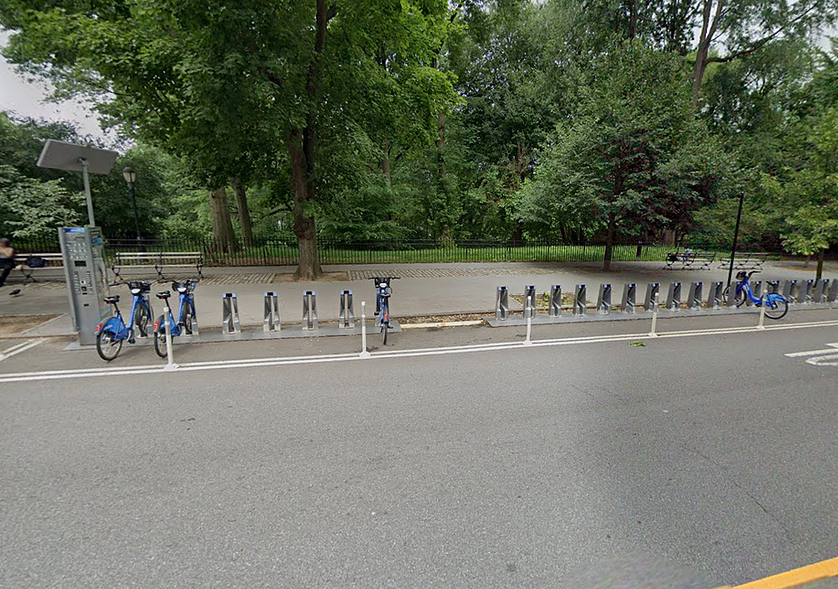



---



##Enriching the Data     

Remember the GPS coordinates of the CUNY CityTech campus are:    
    
* `40.6954° N`    
* `73.9875° W`   

When writing those as decimal values, we use a minus (`-`) sign to indicate degrees west on longitude.   

Let's calculate the distance from each Citibike station record to the CUNY CityTech campus.    


In [ ]:
# We define a function that will take as input a dataframe df
# and returns back a calculated array. This function computes
# the distance (in miles) from CityTech, given the lat/lon of the 
# other location

def distance_all(df):
  CityTech_lat = 40.6954   # per Google
  CityTech_lon = -73.9875  # per Google 

  # The calculation below is simply the Pythagorean theorem.
  # The normalizing values are just for converting lat/lon differences
  # to miles
  distance = ((df.latitude-CityTech_lat)/0.0146)**2 + ((df.longitude-CityTech_lon)/0.0196)**2
  return np.sqrt(distance) 


# We define a function that will take latitude, longitude as input 
# and returns back a calculated value. This function computes
# the distance (in miles) from CityTech, given the lat/lon of the 
# other location

def distance_row(latitude, longitude):
  CityTech_lat = 40.6954   # per Google
  CityTech_lon = -73.9875  # per Google 

  # The calculation below is simply the Pythagorean theorem.
  # The normalizing values are just for converting lat/lon differences
  # to miles
  distance = ((latitude-CityTech_lat)/0.0146)**2 + ((longitude-CityTech_lon)/0.0196)**2
  return np.sqrt(distance) 


In [ ]:
# Let's use the `.assign()` method to calculate the station distance from 
# CityTech using the logic in the `distance()` function in the snippet above    

(
  df
  .assign(
      distance_from_CityTech = distance_all # our df function
  )
  .filter(items = ['start station id',
                   'starttime', 
                   'stoptime',
                   'tripduration',
                   'distance_from_CityTech'])
)

Now, let's use that same function to create a new column in our `df` dataframe 

In [ ]:
# df['Discounted_Price'] = df.apply(lambda x: fxy(x['A'], x['B']), axis=1)

df['distance_from_CityTech'] = df.apply(lambda x: 
                                        distance_row(x['latitude'], 
                                                     x['longitude']), 
                                        axis = 1)  # our value/row function 
                                        

In [ ]:
print('Column Data Types')
print(df.dtypes, '\n\nDataframe Describe')
print(df.describe())

**What was the average trip duration (in hours)\ for Citibike rentals starting within 0.5 miles of CityTech in January 2019?**    

In [ ]:
print(df[df['distance_from_CityTech']<=0.5]['tripduration'].mean() / 60)


**What was the shortest trip duration (in hours)\ for Citibike rentals starting within 0.5 miles of CityTech in January 2019?**   

In [ ]:
print(df[df['distance_from_CityTech']<=0.5]['tripduration'].min() / 60)


**What was the longest trip duration (in hours)\ for Citibike rentals starting within 0.5 miles of CityTech in January 2019?**   

In [ ]:
print(df[df['distance_from_CityTech']<=0.5]['tripduration'].max() / 60)


**That looks a bit odd -- time for some data wrangling...** 

*... to be continued.*   




---

